<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/master/CNN_laboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN_Laboration
```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```

In [75]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

import tensorflow.keras 
print(f'Keras version:      {tensorflow.keras.__version__}')

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.7.0
Keras version:      2.7.0


In [76]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-d1970648-dc1f-f937-9078-8931b409d025)


In [77]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
label_descriptions = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
                      'sandals', 'shirt', 'sneaker', 'bag', 'ankle boots']

def split_random(data, labels, percent_train=80):
    print('Splitting data into training and validation')
    print(f'Training split     = {percent_train}%')
    print(f'Validation split   = {100-percent_train}%')
    indicies = np.arange(data.shape[0])

    for _ in range(4): 
        indicies = np.random.permutation(indicies)

    
    labels = labels[indicies]
    data   = data[indicies]
    rows   = data.shape[0]

    end_index = int(rows*percent_train/100)

    train_x = data[:end_index]
    train_y = labels[:end_index]

    validation_x = data[end_index:]
    validation_y = labels[end_index:]

    return (train_x, train_y), (validation_x, validation_y)

def validate_data(data, labels, data_set_name):
    """
        Naive validation, only validets shape of data compared to labels
    """

    nr_images, x, y = data.shape
    print(f'\nRunning validation on {data_set_name}')
    print(f'Number of images   = {nr_images}')
    print(f'Number of labels   = {len(labels)}')
    print(f'Image dimension    = {x}x{y}')
    if nr_images != len(labels):
        print('Number of images does not match number of labels')
    else:
        print('Data is OK ✅')

(train_x, train_y), (validation_x, validation_y) = split_random(x_train, y_train)

# increase readability since i will use train_x, train_y from here on 
test_x = x_test
test_y = y_test
test_labels = y_test

validate_data(train_x, train_y, "training")
validate_data(validation_x, validation_y, "validation")
validate_data(test_x, test_y, "test")

print(f'\nTrain shape        = {train_x.shape}')
print(f'Validation shape   = {validation_x.shape}')
print(f'Test shape         = {x_test.shape}')
print(f'Unique labels      = {np.unique(train_y)}')
print('Label translation  = ---------------------')
for i, label in enumerate(label_descriptions):
    print(f'                     [{i}]: {label}')
print('                     ---------------------')

Splitting data into training and validation
Training split     = 80%
Validation split   = 20%

Running validation on training
Number of images   = 48000
Number of labels   = 48000
Image dimension    = 28x28
Data is OK ✅

Running validation on validation
Number of images   = 12000
Number of labels   = 12000
Image dimension    = 28x28
Data is OK ✅

Running validation on test
Number of images   = 10000
Number of labels   = 10000
Image dimension    = 28x28
Data is OK ✅

Train shape        = (48000, 28, 28)
Validation shape   = (12000, 28, 28)
Test shape         = (10000, 28, 28)
Unique labels      = [0 1 2 3 4 5 6 7 8 9]
Label translation  = ---------------------
                     [0]: t-shirt/top
                     [1]: trouser
                     [2]: pullover
                     [3]: dress
                     [4]: coat
                     [5]: sandals
                     [6]: shirt
                     [7]: sneaker
                     [8]: bag
                     [9]: ankle 

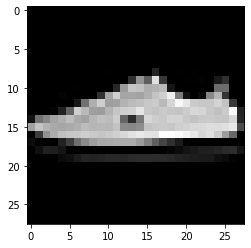

Image #31956 which is digit "7" (sneaker)



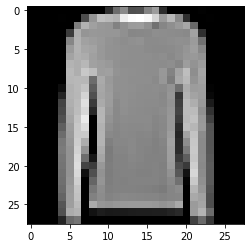

Image #15603 which is digit "2" (pullover)



In [78]:
from random import randrange
def plot_image(digit):
    plt.figure()
    plt.imshow(train_x[digit], cmap='gray', interpolation='nearest')
    plt.show(block=False)
    print(f'Image #{digit} which is digit "{train_y[digit]}" ({label_descriptions[train_y[digit]]})\n')

ran_range = len(train_x) - 1
image_digits = [randrange(ran_range), randrange(ran_range)]
plots = [plot_image(a) for a in image_digits]


In [79]:
from tensorflow.keras.utils import to_categorical

def reshape_data(data, img_width, img_height, channels_first):
    data = data.astype('float32') / 255.0

    if channels_first:
        data = data.reshape(data.shape[0], 1, img_width, img_height)
    else:
       data = data.reshape(data.shape[0], img_width, img_height, 1) 

    return data


In [80]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_model(img_height, img_width, nr_classes, is_chanels_first):
    input_shape = (1, img_width, img_height) if is_channels_first else (img_width, img_height, 1)

    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',
               input_shape=input_shape),
        BatchNormalization(),

        Conv2D(64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Flatten(),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(nr_classes, activation='softmax')
    ])
    return model

In [81]:
epochs                = 15
batch_size            = 32
nr_classes            = len(np.unique(train_y))
_, x, y               = train_x.shape
img_width, img_height = x, y
is_channels_first     = backend.image_data_format() == 'channels_first'


train_x       = reshape_data(train_x, img_width, img_height, is_channels_first)
test_x        = reshape_data(test_x, img_width, img_height, is_channels_first)
validation_x  = reshape_data(validation_x, img_width, img_height, is_channels_first)

train_y       = to_categorical(train_y, nr_classes)
test_y        = to_categorical(test_y, nr_classes)
validation_y  = to_categorical(validation_y, nr_classes)

model = build_model(img_width, img_height, nr_classes, is_channels_first)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                      

In [82]:
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['categorical_accuracy'])

In [83]:
history = model.fit(train_x, train_y, 
            batch_size=batch_size,
            epochs=epochs,
            verbose=2,
            validation_data=(validation_x, validation_y))

Epoch 1/15
1500/1500 - 24s - loss: 0.3949 - categorical_accuracy: 0.8577 - val_loss: 0.3118 - val_categorical_accuracy: 0.8871 - 24s/epoch - 16ms/step
Epoch 2/15
1500/1500 - 23s - loss: 0.2472 - categorical_accuracy: 0.9095 - val_loss: 0.2614 - val_categorical_accuracy: 0.9028 - 23s/epoch - 15ms/step
Epoch 3/15
1500/1500 - 22s - loss: 0.1917 - categorical_accuracy: 0.9301 - val_loss: 0.2319 - val_categorical_accuracy: 0.9164 - 22s/epoch - 15ms/step
Epoch 4/15
1500/1500 - 23s - loss: 0.1525 - categorical_accuracy: 0.9459 - val_loss: 0.2660 - val_categorical_accuracy: 0.9050 - 23s/epoch - 15ms/step
Epoch 5/15
1500/1500 - 22s - loss: 0.1195 - categorical_accuracy: 0.9572 - val_loss: 0.2436 - val_categorical_accuracy: 0.9137 - 22s/epoch - 14ms/step
Epoch 6/15
1500/1500 - 22s - loss: 0.0923 - categorical_accuracy: 0.9680 - val_loss: 0.2198 - val_categorical_accuracy: 0.9245 - 22s/epoch - 15ms/step
Epoch 7/15
1500/1500 - 22s - loss: 0.0684 - categorical_accuracy: 0.9758 - val_loss: 0.2600 - 

In [ ]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

In [84]:
train_loss, train_acc, val_loss, val_acc = retrieve(history.history, 
                                                    'loss',
                                                    'categorical_accuracy',
                                                    'val_loss',
                                                    'val_categorical_accuracy')
print('---- Raw summary ----')                                                  
print(f'Training loss       = {train_loss[epochs-1]}')
print(f'Training Accuracy   = {train_acc[epochs-1]}')

print(f'Validation loss     = {val_loss[epochs-1]}')
print(f'Validation Accuracy = {val_acc[epochs-1]}')

---- Raw summary ----
Training loss       = 0.0012893048115074635
Training Accuracy   = 0.9999791383743286
Validation loss     = 0.3084203898906708
Validation Accuracy = 0.9289166927337646


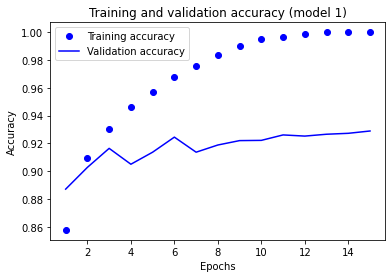

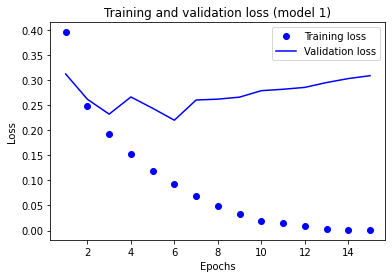

In [85]:
epoch_range = range(1, epochs + 1)
plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (model 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch_range, train_loss, 'bo', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (model 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
model.evaluate(
    test_x,
    test_y
)

313/313 [==============================] - 3s 8ms/step - loss: 0.3337 - categorical_accuracy: 0.9257


[0.3337036073207855, 0.9257000088691711]

In [87]:
predictions = model.predict(test_x[:5])
print(np.argmax(predictions, axis=1))
print(test_labels[:5])
for label in np.argmax(predictions, axis=1):
    print(label_descriptions[label], end=" ")

print()

for label in test_labels[:5]:
    print(label_descriptions[label], end=" ")

[9 2 1 1 6]
[9 2 1 1 6]
ankle boots pullover trouser trouser shirt 
ankle boots pullover trouser trouser shirt 